<a href="https://colab.research.google.com/github/gibina/gibina/blob/master/NAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [4]:
df_small_noise=pd.read_csv("Twitter_volume_AMZN.csv",index_col=0)

In [5]:
df_daily_jumpsup=pd.read_csv("Twitter_volume_AAPL.csv",index_col=0)
print("small noise \n",df_small_noise.head())

small noise 
                      value
timestamp                 
2015-02-26 21:42:53     57
2015-02-26 21:47:53     43
2015-02-26 21:52:53     55
2015-02-26 21:57:53     64
2015-02-26 22:02:53     93


In [6]:
print("Daily jumps",df_daily_jumpsup.head())

Daily jumps                      value
timestamp                 
2015-02-26 21:42:53    104
2015-02-26 21:47:53    100
2015-02-26 21:52:53     99
2015-02-26 21:57:53    154
2015-02-26 22:02:53    120


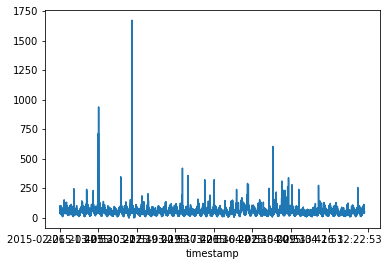

In [11]:
fig, ax= plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

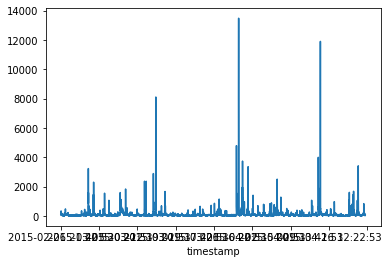

In [12]:
fig, ax=plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

In [13]:
#Normalise and save the mean and std we get
training_mean= df_small_noise.mean()
training_std=df_small_noise.std()

In [14]:
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value),"\n")
print(training_mean, training_std, df_training_value)
print("\n Shape = ",df_training_value.shape)

Number of training samples: 15831 

value    53.298465
dtype: float64 value    30.553147
dtype: float64                         value
timestamp                    
2015-02-26 21:42:53  0.121151
2015-02-26 21:47:53 -0.337067
2015-02-26 21:52:53  0.055691
2015-02-26 21:57:53  0.350260
2015-02-26 22:02:53  1.299425
...                       ...
2015-04-22 20:32:53 -0.075228
2015-04-22 20:37:53  0.022961
2015-04-22 20:42:53 -0.238878
2015-04-22 20:47:53  0.088421
2015-04-22 20:52:53 -0.107958

[15831 rows x 1 columns]

 Shape =  (15831, 1)


In [15]:
TIME_STEPS = 288
import numpy as np

In [16]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [17]:
x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)
print("\n Type of train : ",type(x_train))
print("\n Print : \n",x_train)
print("\n Shape = ",df_training_value.shape)

Training input shape:  (15543, 288, 1)

 Type of train :  <class 'numpy.ndarray'>

 Print : 
 [[[ 0.12115069]
  [-0.33706724]
  [ 0.05569099]
  ...
  [ 1.79037317]
  [ 0.74301789]
  [ 0.12115069]]

 [[-0.33706724]
  [ 0.05569099]
  [ 0.35025966]
  ...
  [ 0.74301789]
  [ 0.12115069]
  [ 0.48117907]]

 [[ 0.05569099]
  [ 0.35025966]
  [ 1.29942538]
  ...
  [ 0.12115069]
  [ 0.48117907]
  [ 0.1866104 ]]

 ...

 [[ 0.28479996]
  [ 0.48117907]
  [ 0.41571937]
  ...
  [ 0.41571937]
  [-0.07522842]
  [ 0.02296114]]

 [[ 0.48117907]
  [ 0.41571937]
  [ 0.21934025]
  ...
  [-0.07522842]
  [ 0.02296114]
  [-0.23887768]]

 [[ 0.41571937]
  [ 0.21934025]
  [-0.14068813]
  ...
  [ 0.02296114]
  [-0.23887768]
  [ 0.08842084]]]

 Shape =  (15831, 1)


In [18]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)

In [19]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [20]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
110/110 [==============================] - 9s 77ms/step - loss: 0.6178 - val_loss: 0.0492
Epoch 2/50
110/110 [==============================] - 9s 78ms/step - loss: 0.1302 - val_loss: 0.0238
Epoch 3/50
110/110 [==============================] - 9s 78ms/step - loss: 0.0896 - val_loss: 0.0187
Epoch 4/50
110/110 [==============================] - 9s 78ms/step - loss: 0.0800 - val_loss: 0.0150
Epoch 5/50
110/110 [==============================] - 9s 77ms/step - loss: 0.0695 - val_loss: 0.0123
Epoch 6/50
110/110 [==============================] - 9s 79ms/step - loss: 0.0619 - val_loss: 0.0111
Epoch 7/50
110/110 [==============================] - 9s 80ms/step - loss: 0.0566 - val_loss: 0.0110
Epoch 8/50
110/110 [==============================] - 9s 78ms/step - loss: 0.0556 - val_loss: 0.0112
Epoch 9/50
110/110 [==============================] - 8s 77ms/step - loss: 0.0526 - val_loss: 0.0113
Epoch 10/50
110/110 [==============================] - 9s 78ms/step - loss: 0.0474 - val_lo

In [21]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)


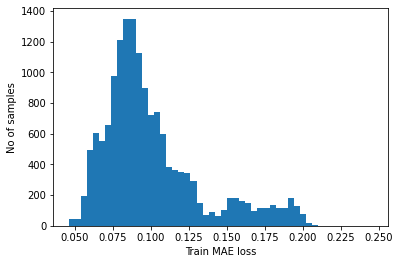

In [22]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

In [23]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

Reconstruction error threshold:  0.24638068466864244


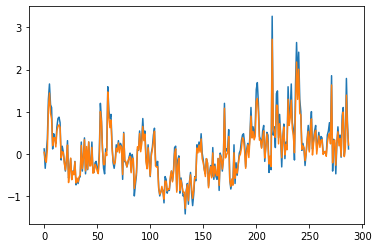

In [24]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [25]:
def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

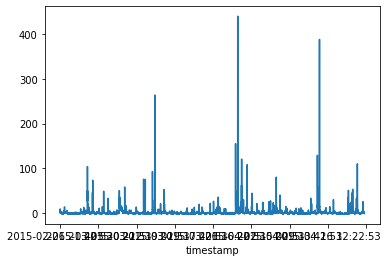

In [26]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [27]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (15614, 288, 1)


In [28]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

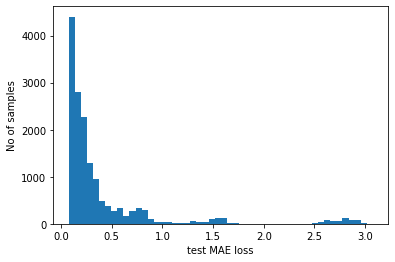

In [29]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [30]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


Number of anomaly samples:  6303
Indices of anomaly samples:  (array([    0,     2,     3, ..., 15536, 15537, 15538]),)


In [31]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

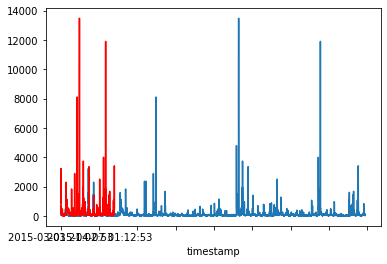

In [32]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()